In [1]:
#import statements, hyper params, models
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore') 
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from numpy import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math


EPOCHS = 50 #number of passes of whole data
BATCH_SIZE = 64 #size of data going through at once
LEARNING_RATE = 0.01
NEURONS=5
XSIZE=10000
BINOMPROB=.5
#X=random.rand(XSIZE, 5)
X=np.random.normal(0, 1, size=(XSIZE, 5))
y=[]
for i in range(XSIZE):
    y.append(random.binomial(1, BINOMPROB, size=None))




#Data class
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#Data loaders (to look at data) and deal with data (training and testing)
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
def binary_acc(y_pred, y_test): 
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def trainnetwork(network, train_loader,stats=True):
    network.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)


    network.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = network(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        
def evalnetwork(network, test_loader, stats=True, output=False):
    y_pred_list =[]
    network.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = network(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())


    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    if(stats):
        statistics(y_pred_list)
    if output:
        return y_fullmodelpred_list

    
    
    
    
    
    
    
    
    
    
    

def resettruth(truth_loader):
    y_pred_list =[]
    GroundTruth.eval()
    with torch.no_grad():
        for X_batch in truth_loader:
            X_batch = X_batch.to(device)
            y_test_pred = GroundTruth(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())


    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return y_pred_list

    
    

def statistics(y_pred_list):
    correctcounter=0
    for i in range(len(y_pred_list)):
        if y_pred_list[i]==y_test[i]:
            correctcounter=correctcounter+1       

    print("# correct: ",correctcounter, " out of ", len(y_test))

    print("Model statistics")
    print(classification_report(y_test, y_pred_list))    
    
#model class 5 layers, then an output layer
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        self.layer_1 = nn.Linear(5, NEURONS) 
        self.layer_2 = nn.Linear(NEURONS, NEURONS) 
        self.layer_3 = nn.Linear(NEURONS, NEURONS)
        self.layer_4 = nn.Linear(NEURONS,NEURONS)
        self.layer_5 = nn.Linear(NEURONS, NEURONS) 
        self.layer_out = nn.Linear(NEURONS, 1) #output layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        self.batchnorm1 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2 = nn.BatchNorm1d(NEURONS)
        self.batchnorm3 = nn.BatchNorm1d(NEURONS)
        self.batchnorm4 = nn.BatchNorm1d(NEURONS)
        self.batchnorm5 = nn.BatchNorm1d(NEURONS)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)        
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
#parallel model (two 5 layer models, with output going into new output layer)
class parallelmodel(nn.Module):
    def __init__(self, originalmodel):
        super(parallelmodel, self).__init__()
        self.layer1_1 = copy.deepcopy(originalmodel.layer_1)
        self.layer1_2 = copy.deepcopy(originalmodel.layer_2)
        self.layer1_3 = copy.deepcopy(originalmodel.layer_3)
        self.layer1_4 = copy.deepcopy(originalmodel.layer_4)
        self.layer1_5 = copy.deepcopy(originalmodel.layer_5)
        self.layer1_out = copy.deepcopy(originalmodel.layer_out)
        
        self.relu1 = copy.deepcopy(originalmodel.relu)        
        self.dropout1 = copy.deepcopy(originalmodel.dropout)
        
        self.batchnorm1_1 = copy.deepcopy(originalmodel.batchnorm1)
        self.batchnorm1_2 = copy.deepcopy(originalmodel.batchnorm2)
        self.batchnorm1_3 = copy.deepcopy(originalmodel.batchnorm3)
        self.batchnorm1_4 = copy.deepcopy(originalmodel.batchnorm4)
        self.batchnorm1_5 = copy.deepcopy(originalmodel.batchnorm5)
        #self.batchnorm1_out=nn.BatchNorm1d(1)

        
        self.batchnorm2_1 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_2 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_3 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_4 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_5 = nn.BatchNorm1d(NEURONS)
        #self.batchnorm2_out=nn.BatchNorm1d()
        
        self.layer2_1 = nn.Linear(5, NEURONS) 
        self.layer2_2 = nn.Linear(NEURONS, NEURONS) 
        self.layer2_3 = nn.Linear(NEURONS,NEURONS)
        self.layer2_4 = nn.Linear(NEURONS, NEURONS)
        self.layer2_5 = nn.Linear(NEURONS, NEURONS) 
        self.layer2_out = nn.Linear(NEURONS, 1) 
        
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)
        
        #changed bias
        self.outputlayer= nn.Linear(2, 1, bias=False )
        self.alpha=[]
        self.beta=[]
        
        
        
        
        
    def forward(self, inputs):
        x = self.relu1(self.layer1_1(inputs))
        x = self.batchnorm1_1(x)
        x = self.relu1(self.layer1_2(x))
        x = self.batchnorm1_2(x)
        x = self.relu1(self.layer1_3(x))
        x = self.batchnorm1_3(x)
        x = self.relu1(self.layer1_4(x))
        x = self.batchnorm1_4(x)
        x = self.relu1(self.layer1_5(x))
        x = self.batchnorm1_5(x) 
        x = self.dropout1(x)
        x = self.layer1_out(x)
        x=torch.sigmoid(x)
        
        
        y = self.relu2(self.layer2_1(inputs))
        y = self.batchnorm2_1(y)
        y = self.relu2(self.layer2_2(y))
        y = self.batchnorm2_2(y)
        y = self.relu2(self.layer2_3(y))
        y = self.batchnorm2_3(y)
        y = self.relu2(self.layer2_4(y))
        y = self.batchnorm2_4(y)
        y = self.relu2(self.layer2_5(y))
        y = self.batchnorm2_5(y)        
        y = self.dropout2(y)
        y = self.layer2_out(y)
        y=torch.sigmoid(y)
        
        z=self.outputlayer(torch.cat([x, y], dim=1))
        return z
        
#parrallel submodels
class parrallel_submodel(nn.Module):
    def __init__(self):
        super(parrallel_submodel, self).__init__()
        self.layer_1 = nn.Linear(5, NEURONS) 
        self.layer_2 = nn.Linear(NEURONS, NEURONS) 
        self.layer_3 = nn.Linear(NEURONS, NEURONS)
        self.layer_4 = nn.Linear(NEURONS,NEURONS)
        self.layer_5 = nn.Linear(NEURONS, NEURONS) 
        self.layer_out = nn.Linear(NEURONS, 1) #output layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        self.batchnorm1 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2 = nn.BatchNorm1d(NEURONS)
        self.batchnorm3 = nn.BatchNorm1d(NEURONS)
        self.batchnorm4 = nn.BatchNorm1d(NEURONS)
        self.batchnorm5 = nn.BatchNorm1d(NEURONS)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)        
        x = self.dropout(x)
        x = self.layer_out(x)
        x = torch.sigmoid(x)
        
        return x
    
#parallel model V2
class parallelmodel1(nn.Module):
    def __init__(self, originalmodel):
        super(parallelmodel1, self).__init__()

        self.pretrainednetwork=parrallel_submodel()
        
        
        
        
        self.pretrainednetwork.layer_1 = copy.deepcopy(originalmodel.layer_1)
        self.pretrainednetwork.layer_2 = copy.deepcopy(originalmodel.layer_2)
        self.pretrainednetwork.layer_3 = copy.deepcopy(originalmodel.layer_3)
        self.pretrainednetwork.layer_4 = copy.deepcopy(originalmodel.layer_4)
        self.pretrainednetwork.layer_5 = copy.deepcopy(originalmodel.layer_5)
        self.pretrainednetwork.layer_out = copy.deepcopy(originalmodel.layer_out)
        
        self.pretrainednetwork.relu = copy.deepcopy(originalmodel.relu)        
        self.pretrainednetwork.dropout = copy.deepcopy(originalmodel.dropout)
        
        self.pretrainednetwork.batchnorm_1 = copy.deepcopy(originalmodel.batchnorm1)
        self.pretrainednetwork.batchnorm_2 = copy.deepcopy(originalmodel.batchnorm2)
        self.pretrainednetwork.batchnorm_3 = copy.deepcopy(originalmodel.batchnorm3)
        self.pretrainednetwork.batchnorm_4 = copy.deepcopy(originalmodel.batchnorm4)
        self.pretrainednetwork.batchnorm_5 = copy.deepcopy(originalmodel.batchnorm5)

        
        self.untrainednetwork=parrallel_submodel()
        
        
        self.outputlayer= nn.Linear(2, 1, bias=False )
        
        

        self.alpha=[]
        self.beta=[]
        
        
        
        
        self.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[1.0,1.0]]), requires_grad=True)
        self.alpha.append(1.0)
        self.beta.append(1.0)
        
    def forward(self, inputs):
        x=self.pretrainednetwork(inputs)
        y=self.untrainednetwork(inputs)
        z=self.outputlayer(torch.cat([x, y], dim=1))
        return z






    
    
#groundtruth model  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



baddata=True
while(baddata):
    GroundTruth = binaryClassification()

    
    

    
    
    scaler=StandardScaler()
    
    X_train = scaler.fit_transform(X) 
    X_test=scaler.fit_transform(X)
    
    train_data = trainData(torch.FloatTensor(X_train),torch.FloatTensor(y))
    test_data = testData(torch.FloatTensor(X_test))
    
    
    
    Truthloadertrain=DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    Truthtest= DataLoader(dataset=test_data, batch_size=1)

    
    
    
    
    
    trainnetwork(GroundTruth, Truthloadertrain)
    truth_list = resettruth(Truthtest)
    truthcounter=truth_list.count(1)
            
    
            
    if truthcounter/len(y)<BINOMPROB+.3 and truthcounter/len(y)>BINOMPROB-.3:
        baddata=False
        y=truth_list
        
        
        
        
    else:
        print("rejected truths ", truth_list.count(1))
        X=np.random.normal(0, 1, size=(XSIZE, 5))
        y=[]
        for i in range(XSIZE):
            y.append(random.binomial(1, BINOMPROB, size=None))

 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
train_data= trainData(torch.FloatTensor(X_train),torch.FloatTensor(y_train))
test_data = testData(torch.FloatTensor(X_test))
train_loader= DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)                      
test_loader = DataLoader(dataset=test_data, batch_size=1)
trained=binaryClassification()
trainnetwork(trained, train_loader)
evalnetwork(trained, test_loader)


    

# correct:  3204  out of  3300
Model statistics
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1716
         1.0       0.98      0.96      0.97      1584

    accuracy                           0.97      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.97      0.97      0.97      3300



In [2]:
#train parralel model
parallelv2=parallelmodel1(trained)






parallelv2.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(parallelv2.parameters(), lr=LEARNING_RATE)


parallelv2.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = parallelv2(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()
        
        parallelv2.alpha.append(parallelv2.outputlayer.weight[0][0].detach().numpy().item())
        parallelv2.beta.append(parallelv2.outputlayer.weight[0][1].detach().numpy().item())

        epoch_loss += loss.item()
        epoch_acc += acc.item()







pretrainedpartialnetwork=parallelv2.pretrainednetwork
untrainedpartialnetwork=parallelv2.untrainednetwork



trainnetwork(trained, train_loader)
evalnetwork(trained, test_loader)




print("pretrained stats:")



y_pretrianedlist =[]
y_pretrainedunrounded=[]
pretrainedpartialnetwork.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = pretrainedpartialnetwork(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        y_pretrainedunrounded.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_pretrianedlist.append(y_pred_tag.cpu().numpy())


y_pretrianedlist = [a.squeeze().tolist() for a in y_pretrianedlist]
y_pretrainedunrounded = [a.squeeze().tolist() for a in y_pretrainedunrounded]



trainedcorrectcounter=0
for i in range(len(y_pretrianedlist)):
    if y_pretrianedlist[i]==y_test[i]:
        trainedcorrectcounter=trainedcorrectcounter+1 
        
        
print("Tained half model;")
print("Number correct model: ", trainedcorrectcounter, " out of ", len(y_test))
print("precision=(# of correct)/(# of guessed)")
print("recall=(# of correct)/(total)")
print(classification_report(y_test, y_pretrianedlist))



print("untrained half stats:")
y_untrianedlist =[]
y_untrained_unrounded=[]
untrainedpartialnetwork.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = untrainedpartialnetwork(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        y_untrained_unrounded.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_untrianedlist.append(y_pred_tag.cpu().numpy())


y_untrianedlist = [a.squeeze().tolist() for a in y_untrianedlist]
y_untrained_unrounded = [a.squeeze().tolist() for a in y_untrained_unrounded]



untrainedcorrectcounter=0
for i in range(len(y_pretrianedlist)):
    if y_untrianedlist[i]==y_test[i]:
        untrainedcorrectcounter=untrainedcorrectcounter+1 
        

        
andcorrectcounter=0
for i in range(len(y_pretrianedlist)):
    if y_untrianedlist[i]==y_test[i] and y_pretrianedlist[i]==y_test[i]:
        andcorrectcounter=andcorrectcounter+1


probabilityboth=andcorrectcounter/len(y_pretrianedlist)
        
print("untained half model;")
print("Number correct model: ", untrainedcorrectcounter, " out of ", len(y_test))
print("precision=(# of correct)/(# of guessed)")
print("recall=(# of correct)/(total)")
print(classification_report(y_test, y_untrianedlist))



untrainedcounter=0
trainedcounter=0

for i, j,k in zip(y_pretrianedlist, y_untrianedlist, y_test):
    if i==k and j!=k:
        trainedcounter=trainedcounter+1
    elif i!=k and j==k:
        untrainedcounter=untrainedcounter+1
prob_pre_notun=round(trainedcounter/(len(y_untrianedlist)-untrainedcorrectcounter),4)
prob_un_notpre=round(untrainedcounter/(len(y_untrianedlist)-trainedcorrectcounter),4)

print("P(pretrained correct | untrained incorrect)= ", prob_pre_notun)
print("P(untrained correct | pretrained incorrect)= ", prob_un_notpre)
print("P(pretrianed and untrained)= ", probabilityboth)

print("Pearson correlational")
print(np.corrcoef(y_untrianedlist,y_pretrianedlist)[0][1])









# correct:  2765  out of  3300
Model statistics
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82      1716
         1.0       0.76      0.96      0.85      1584

    accuracy                           0.84      3300
   macro avg       0.86      0.84      0.84      3300
weighted avg       0.86      0.84      0.84      3300

pretrained stats:
Tained half model;
Number correct model:  2947  out of  3300
precision=(# of correct)/(# of guessed)
recall=(# of correct)/(total)
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90      1716
         1.0       0.97      0.80      0.88      1584

    accuracy                           0.89      3300
   macro avg       0.91      0.89      0.89      3300
weighted avg       0.90      0.89      0.89      3300

untrained half stats:
untained half model;
Number correct model:  1716  out of  3300
precision=(# of correct)/(# of guessed)
recall=(# of correct)/(t

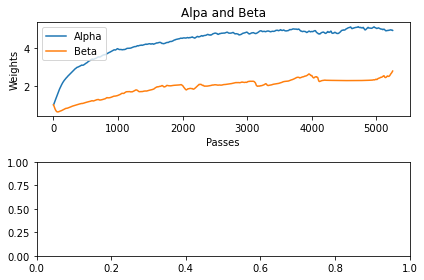

In [3]:
#graphs
passlist=list(range(1,len(parallelv2.alpha)+1))
fig, (weights, lossgraph) = plt.subplots(2)
weights.plot(passlist,parallelv2.alpha, label="Alpha")
weights.plot(passlist,parallelv2.beta, label="Beta")
weights.legend()

weights.set_xlabel('Passes')
weights.set_ylabel('Weights')
weights.set_title('Alpa and Beta')




#plt.plot(epochlist,losslist, label="loss")

#lossgraph.set_xlabel('Epochs')
#lossgraph.set_label('Loss')
#lossgraph.set_title('Loss')


fig.tight_layout()
#plt.savefig('e2fullparalelgraph3')



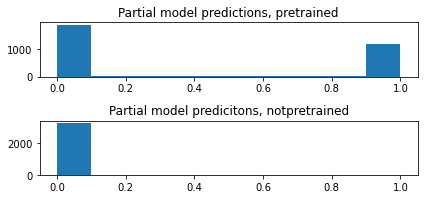

In [4]:
#histograms
xbins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
fig=plt.figure()
trained_histo=fig.add_subplot(3,1,1)
untrained_histo=fig.add_subplot(3,1,2)
#full_histo=fig.add_subplot(3,1,3)

n, bins, patches = trained_histo.hist(y_pretrainedunrounded,xbins)
n, bins, patches = untrained_histo.hist(y_untrained_unrounded,xbins)
#n, bins, patches = full_histo.hist(yparralelunrounded,xbins)




untrained_histo.set_title('Partial model predicitons, notpretrained')
trained_histo.set_title("Partial model predictions, pretrained")
#full_histo.set_title("Full model predictions")
fig.tight_layout()



#plt.savefig('HIST_TRe2_N64_D10000_FULL_NOBIAS')


CDF given 0, then given 1 (X=pretrained, Y=untrained)


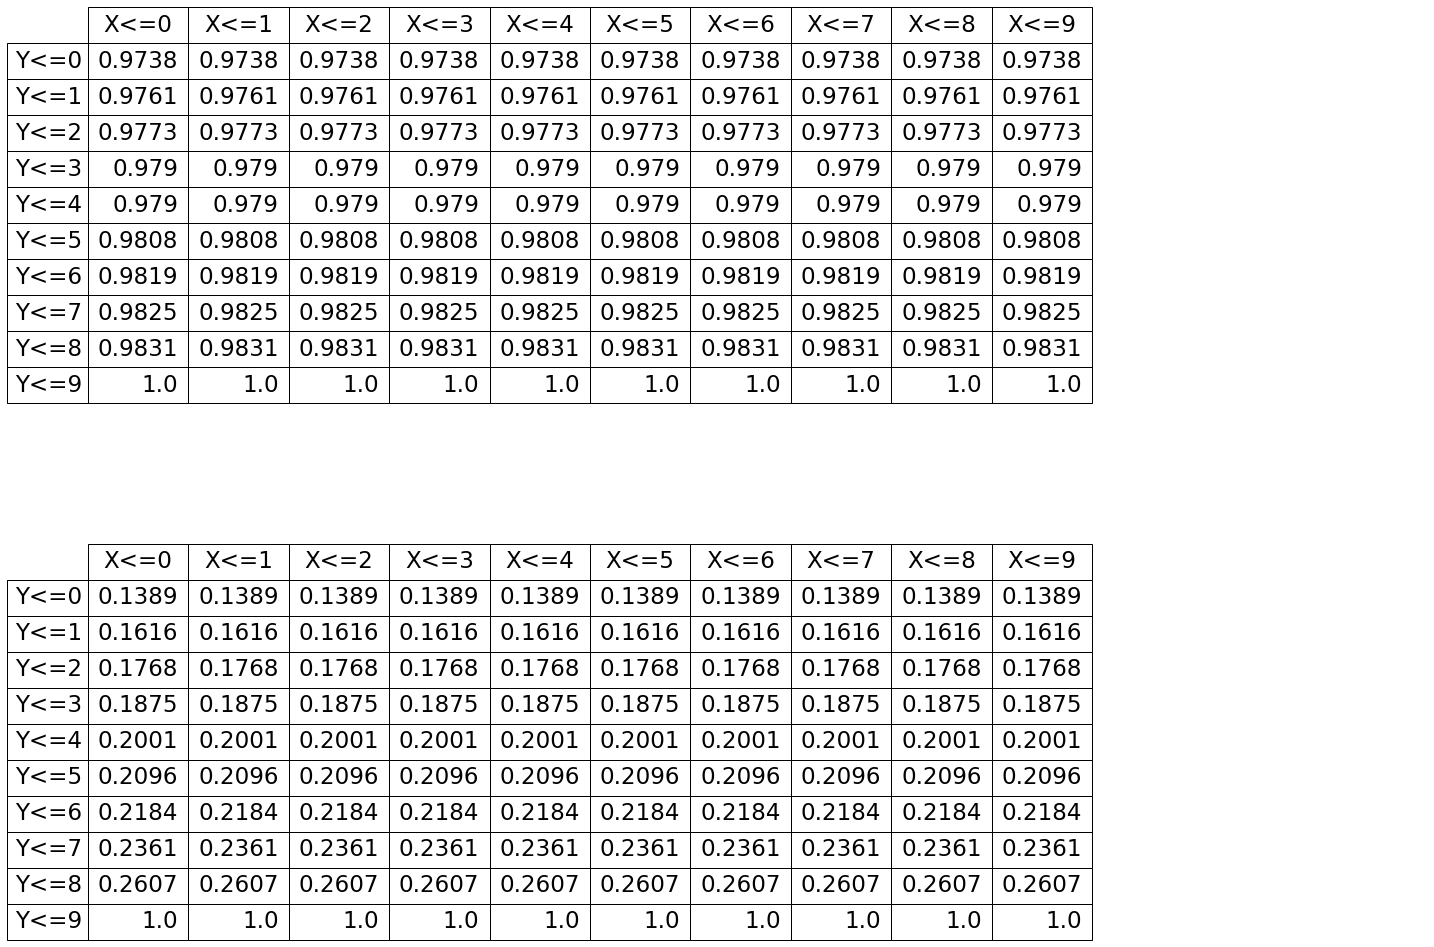

In [5]:
#CDFS
from matplotlib.pyplot import figure
import math



    
    
y0_pretrainedunrounded=[]
y1_pretrainedunrounded=[]
y0_untrained_unrounded=[]
y1_untrained_unrounded=[]

y_untrained_unroundedbins=[math.floor(a*10) for a in y_untrained_unrounded]
y_pretrainedunroundedbins=[math.floor(a*10) for a in y_pretrainedunrounded]


for (test, trained, untrained) in zip(y_test, y_pretrainedunroundedbins, y_untrained_unroundedbins):
    
    if test==0:
        y0_pretrainedunrounded.append(trained)
        y0_untrained_unrounded.append(untrained)


    else:
        y1_pretrainedunrounded.append(trained)
        y1_untrained_unrounded.append(untrained)

    
    
    



    
    
    


count=0
pmfgiven0=[]
for i in range(0,10):
    pmfgiven0.append([])
    for j in range(0,10):
        count=0
        #print("count: ", count)
        for k in range(0, len(y0_pretrainedunrounded)):
            if y0_pretrainedunrounded[k]==i and y0_untrained_unrounded[k]==j:
                count=count+1
            

        pmfgiven0[i].append(count/len(y0_pretrainedunrounded))

        



count=0
pmfgiven1=[]
for i in range(0,10):
    pmfgiven1.append([])
    for j in range(0,10):
        count=0
        #print("count: ", count)
        for k in range(0, len(y1_pretrainedunrounded)):
            if y1_pretrainedunrounded[k]==i and y1_untrained_unrounded[k]==j:
                count=count+1
            

        pmfgiven1[i].append(count/len(y1_pretrainedunrounded))

        
        
           
        


cdfgiven0=[np.cumsum(i) for i in pmfgiven0]
cdfgiven0=[i.tolist() for i in cdfgiven0]


for i in range(1,10):
    cdfgiven0[i]=[x + y for x, y in zip(cdfgiven0[i], cdfgiven0[i-1])]


    
    
cdfgiven1=[np.cumsum(i) for i in pmfgiven1]
cdfgiven1=[i.tolist() for i in cdfgiven1]


for i in range(1,10):
    cdfgiven1[i]=[x + y for x, y in zip(cdfgiven1[i], cdfgiven1[i-1])]
  
        



cdfgiven1=[[round(x,4) for x in i] for i in cdfgiven1]
cdfgiven0=[[round(x,4) for x in i] for i in cdfgiven0]

Xlabel=["X<="+str(e) for e in range(0,10)]  
Ylabel=["Y<="+str(e) for e in range(0,10)]  


fig=plt.figure()
ax=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2)
print("CDF given 0, then given 1 (X=pretrained, Y=untrained)")

ax.set_axis_off() 
cdf0table=ax.table(cellText=cdfgiven0,rowLabels=Ylabel, colLabels=Xlabel,loc='top left')
cdf0table.set_fontsize(24)
cdf0table.scale(3,3)

ax2.set_axis_off() 
cdf1table=ax2.table(cellText=cdfgiven1,rowLabels=Ylabel, colLabels=Xlabel,loc='bottom left')
cdf1table.set_fontsize(24)
cdf1table.scale(3,3)

